# Yin-Yangパズル

`````{admonition} Yin-Yangパズルのサイト
:class: tip
https://www.puzzle-yin-yang.com/

`helper.puzzle.extract_yinyan()` を使うと、このサイトのパズル盤面を取得できます。ブラウザの開発者ツールを開き、盤面を表す `<div>` タグのコードをコピーし、この関数を実行すると、盤面が配列として取得できます。
`````

Yin-Yangは、シンプルなルールと奥深い解法を持つロジックパズルです。長方形のグリッド上でプレイされ、一部のマスには最初から黒または白の碁石が置かれています。それ以外のマスは空白です。目標は、すべてのマスを次の条件を満たすように塗り分けることです。  

1. すべての黒いマスが、直交方向（上下左右）の接続によって1つのグループになるようにする。  
2. すべての白いマスが、直交方向の接続によって1つのグループになるようにする。  
3. 同じ色の2×2の領域を作ってはいけない。  

以下に、パズルの解を示します。中心に点があるマスは、最初から存在する碁石を表します。  

![](images/yinyang.png)

## パズルの盤面

パズルの盤面は、以下の配列で定義されます。1は白い碁石、2は黒い碁石、0は空白のマスを表します。  

In [6]:
import numpy as np
puzzle = np.loadtxt('data/yinyang01.txt', dtype=np.uint8)
print(puzzle)

[[0 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 0 0]
 [0 2 0 0 0 0]
 [1 0 2 1 0 0]]


In [89]:
from ortools.sat.python import cp_model
import numpy as np
from collections import defaultdict

### 解く方法  

このパズルの解法はルートを見つけることですが、`add_circuit()` のような回路とは異なるため、自分でルートを作成するための制約条件を設定する必要があります。以下に、その制約条件を示します。  

隣接する2つのマスの変数を、それぞれ `cell1`、`cell2`、`number1`、`number2`、`edge12`、`edge21` とします。  

- **`cell`（ブール変数）**: 白と黒を表す。  
- **`number`（整数変数）**: ルートの向きを表す。  
- **`edge12`・`edge21`（ブール変数）**: 隣接する2つのマス間の有向辺を表す。  
  - `edge12` はマス1からマス2への辺を表し、`edge21` はマス2からマス1への辺を表す。  

以下の制約条件を満たすようにルールを設定します。  

1. **相互排他制約**: `edge12` と `edge21` の両方が 1 になることはない。  
2. **接続ルール**: `edge12` または `edge21` が 1 の場合、`cell1 == cell2`（同じ色である）。  
3. **分離ルール**: `edge12` と `edge21` の両方が 0 の場合、`cell1 != cell2`（異なる色である）。  
4. **色の連結性**: `cell1 == cell2` の場合、`edge12` または `edge21` のどちらかが 1 である。  
5. **番号の順序**: `edge12` が 1 の場合、`number1 < number2` である。  
6. **逆方向の番号の順序**: `edge21` が 1 の場合、`number1 > number2` である。  

初期条件に応じて次の制約条件を追加します。

- 初期状態として、白マスと黒マスからそれぞれ1つを選択し、その2つのマスの `number` を 0 に設定する。  
- この2つのマスには入力辺がないという制約条件を追加する。  
- その他のマスについては、入力辺が **必ず1つだけ存在する** という制約条件を設定する。

以下のグラフは、上記のパズルにおけるすべての変数を可視化したものです。数字0の碁石は、初期状態で選択した1つの白碁石と1つの黒碁石を示します。この2つの碁石を起点として、数字が大きくなる順に碁石を配置し、ルートを生成します。隣接するマスに碁石を置く際には、対応する辺も生成されます。このグラフからわかるように、初期の2つのマスを除くすべてのマスは、必ず隣接するマスから移動してくることになります。辺の変数と数字の順序を適切に設定することで、同じ色のすべての碁石が最初の碁石と確実につながることが保証されます。  

![](images/yinyang2.png)

## コード

以下はYin-Yangパズルを解くコードです。

In [8]:
def select_center(puzzle, val):
    h, w = puzzle.shape
    y, x = np.where(puzzle == val)
    idx = np.argmin(np.hypot(y - h / 2, x - w / 2))
    return y[idx], x[idx]

def select_first(puzzle, val):
    y, x = np.where(puzzle == val)
    return y[0], x[0]

def select_last(puzzle, val):
    y, x = np.where(puzzle == val)
    return y[-1], x[-1]

def solve_yinyang(puzzle):
    model = cp_model.CpModel()
    h, w = puzzle.shape
    edges = []
    
    cell_colors = {}
    cell_numbers = {}
    
    for (r, c), v in np.ndenumerate(puzzle):
        cell_colors[r, c] = model.new_bool_var(f'color_{r}_{c}')
        cell_numbers[r, c] = model.new_int_var(0, h * w, f'step_{r}_{c}')
        c1 = c + 1
        r1 = r + 1
        if c1 < w:
            edges.extend([(r, c, r, c1), (r, c1, r, c)])
        if r1 < h:
            edges.extend([(r, c, r1, c), (r1, c, r, c)])
    
    edge_variables = {edge:model.new_bool_var(f'edge_{edge}') for edge in edges}
    
    out_edges = defaultdict(list)
    in_edges = defaultdict(list)
    
    for (r, c, r1, c1) in edges:
        out_edges[r, c].append((r, c, r1, c1))
        in_edges[r1, c1].append((r, c, r1, c1))
        
    start_locs = [select_first(puzzle, 1), select_first(puzzle, 2)]
    
    for (r1, c1, r2, c2) in edges:
        n1 = r1, c1
        n2 = r2, c2
        if n1 > n2:
            continue
            
        cell1, cell2 = cell_colors[n1], cell_colors[n2]
        number1, number2 = cell_numbers[n1], cell_numbers[n2]
        edge12, edge21 = edge_variables[r1, c1, r2, c2], edge_variables[r2, c2, r1, c1]

        model.add_bool_or(~edge12, ~edge21)
        model.add_bool_or(~cell1, cell2, ~edge12)
        model.add_bool_or(cell1, ~cell2, ~edge12)
        model.add_bool_or(~cell1, cell2, ~edge21)
        model.add_bool_or(cell1, ~cell2, ~edge21)
        model.add_bool_or(cell1, cell2, edge12, edge21)
        model.add_bool_or(~cell1, ~cell2, edge12, edge21)
    
        # model.add_bool_or(~edge12, ~edge21)
        # model.add(cell1 == cell2).only_enforce_if(edge12)
        # model.add(cell1 == cell2).only_enforce_if(edge21)
        # model.add(cell1 != cell2).only_enforce_if(~edge12, ~edge21)
        # model.add_bool_or(edge12, edge21).only_enforce_if(cell1, cell2)
        # model.add_bool_or(edge12, edge21).only_enforce_if(~cell1, ~cell2)
        
        model.add(number1 < number2).only_enforce_if(edge12)
        model.add(number1 > number2).only_enforce_if(edge21)
    
    for (r, c), v in np.ndenumerate(puzzle):
        in_vars = [edge_variables[v] for v in in_edges[r, c]]
        out_vars = [edge_variables[v] for v in out_edges[r, c]]
        if (r, c) not in start_locs:
            model.add(sum(in_vars) == 1)
            model.add(cell_numbers[r, c] > 0)
        else:
            model.add(sum(in_vars) == 0)
            model.add(sum(out_vars) > 0)
            model.add(cell_numbers[r, c] == 0)
                
        if v == 1:
            model.add_bool_and(~cell_colors[r, c])
        elif v == 2:
            model.add_bool_and(cell_colors[r, c])
    
    solver = cp_model.CpSolver()
    solver.solve(model)
    cells = {key:solver.value(val) for key, val in cell_colors.items()}
    numbers = {key:solver.value(val) for key, val in cell_numbers.items()}
    edges = [key for key, val in edge_variables.items() if solver.value(val)]
    return cells, numbers, edges

## 解説

### ヘルパー関数

```python
def select_center(puzzle, val):
    h, w = puzzle.shape
    y, x = np.where(puzzle == val)
    idx = np.argmin(np.hypot(y - h / 2, x - w / 2))
    return y[idx], x[idx]
```
- `val` の値（1 または 2）を持つマスのうち、**盤面の中心に最も近いマス** を選択する関数。

```python
def select_first(puzzle, val):
    y, x = np.where(puzzle == val)
    return y[0], x[0]
```
- `val` の値を持つ **最初のマス**（リストの最初の要素）を選択する関数。

```python
def select_last(puzzle, val):
    y, x = np.where(puzzle == val)
    return y[-1], x[-1]
```
- `val` の値を持つ **最後のマス**（リストの最後の要素）を選択する関数。

これらの関数は、Yin-Yang パズルの開始位置を決定するのに使用される。

### 変数の定義

```python
h, w = puzzle.shape
edges = []
cell_colors = {}
cell_numbers = {}
```

- `h, w` は盤面の高さ・幅。
- `edges` は 隣接するマス同士をつなぐ辺のリスト。
- `cell_colors` は 各マスの色（白 or 黒）を表すブール変数。
- `cell_numbers` は 各マスのルート内の順番を示す整数変数。

```python
for (r, c), v in np.ndenumerate(puzzle):
    cell_colors[r, c] = model.new_bool_var(f'color_{r}_{c}')
    cell_numbers[r, c] = model.new_int_var(0, h * w, f'step_{r}_{c}')
```
- 各マスごとに変数を作成：
  - `cell_colors[r, c]` は 白(0) or 黒(1)
  - `cell_numbers[r, c]` は ルート内の順番を表す整数 (0 〜 h*w の範囲)

### 辺の作成

```python
if c + 1 < w:
    edges.extend([(r, c, r, c+1), (r, c+1, r, c)])
if r + 1 < h:
    edges.extend([(r, c, r+1, c), (r+1, c, r, c)])
```
- 各マスに対して 右・下のマス** との間に双方向の辺を設定。

```python
edge_variables = {edge: model.new_bool_var(f'edge_{edge}') for edge in edges}
```
- 各辺に対して ブール変数を作成し、辺が選択されるかどうかを表す。

```python
out_edges = defaultdict(list)
in_edges = defaultdict(list)

for (r, c, r1, c1) in edges:
    out_edges[r, c].append((r, c, r1, c1))
    in_edges[r1, c1].append((r, c, r1, c1))
```
- `out_edges`：各マスから出る辺のリスト。
- `in_edges`：各マスに入る辺のリスト。

### 初期位置の設定

```python
start_locs = [select_first(puzzle, 1), select_first(puzzle, 2)]
```
- 最初の白と黒のマスを選択（ルートの開始地点）。

### 隣接マス間の制約

```python
for (r1, c1, r2, c2) in edges:
    n1 = r1, c1
    n2 = r2, c2
    if n1 > n2:
        continue
```
- 各隣接マス間でルールを適用する。

```python
model.add_bool_or(~edge12, ~edge21)
```
- 辺は一方向のみ通れる（相互排他制約）。

```python
model.add_bool_or(~cell1, cell2, ~edge12)
model.add_bool_or(cell1, ~cell2, ~edge12)
model.add_bool_or(~cell1, cell2, ~edge21)
model.add_bool_or(cell1, ~cell2, ~edge21)
model.add_bool_or(cell1, cell2, edge12, edge21)
model.add_bool_or(~cell1, ~cell2, edge12, edge21)
```
- 同じ色のマス同士でのみ辺をつなげる。演算速度を向上させるために、これらの制約条件は CNF 形式で実装されている。コメントアウトされたコードは本来のロジックである。

```python
model.add(number1 < number2).only_enforce_if(edge12)
model.add(number1 > number2).only_enforce_if(edge21)
```

- 辺の向きの沿い、ルートの数字は単調増加。


## 各マスの制約

```python
for (r, c), v in np.ndenumerate(puzzle):
    in_vars = [edge_variables[v] for v in in_edges[r, c]]
    out_vars = [edge_variables[v] for v in out_edges[r, c]]
    
    if (r, c) not in start_locs:
        model.add(sum(in_vars) == 1)
        model.add(cell_numbers[r, c] > 0)
    else:
        model.add(sum(in_vars) == 0)
        model.add(sum(out_vars) > 0)
        model.add(cell_numbers[r, c] == 0)
```
- 開始マス以外のマス

  - 入力辺はちょうど1本。
  - `cell_numbers[r, c] > 0`（ルート内の位置が設定される）。

- 開始マス：
  - 入力辺は0本。
  - 出力辺は1本以上。
  - `cell_numbers[r, c] == 0`（スタート地点）。

```python
if v == 1:
    model.add_bool_and(~cell_colors[r, c])
elif v == 2:
    model.add_bool_and(cell_colors[r, c])
```
- 盤面の固定された色を反映。

In [91]:
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection

def plot_yinyang(puzzle, cells=None, numbers=None, edges=None, scale=0.3):
    h, w = puzzle.shape
    fig, ax = plt.subplots(figsize=(w * scale, h * scale))

    if cells is not None:
        xs = []
        ys = []
        colors = []
        for (y, x), v in cells.items():
            xs.append(x)
            ys.append(y)
            colors.append('white' if v == 0 else 'black')
        ax.scatter(xs, ys, s=80 * scale / 0.1, c=colors)        

    if numbers:
        for (r, c), num in numbers.items():
            color = 'black' if cells[r, c] == 0 else 'white'
            ax.text(c, r, str(num), color=color, size=9)

    if edges:
        segments = []
        for r1, c1, r2, c2 in edges:
            segments.append([(c1, r1), (c2, r2)])
        ax.add_collection(LineCollection(segments, alpha=0.7))
    
    y, x = np.where(puzzle == 1)
    ax.scatter(x, y, s=8, edgecolor="#000000", facecolor="none")
    
    y, x = np.where(puzzle == 2)
    ax.scatter(x, y, s=8, edgecolor="#ffffff", facecolor="none")
    
    ax.set_aspect('equal')
    fig.patch.set_facecolor('#777777')

    ax.set_xlim(-0.5, w - 0.5)
    ax.set_ylim(-0.5, h - 0.5)
    ax.invert_yaxis()    
    ax.axis('off');
    return fig, ax

## 問題を解く

パズルサイトの実際の問題を解いてみます。

CPU times: total: 9.34 s
Wall time: 1.59 s


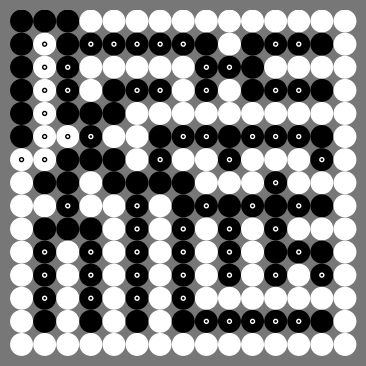

In [94]:
%%time
puzzle = np.loadtxt('data/yinyang02.txt', dtype=np.uint8)
cells, numbers, edges = solve_yinyang(puzzle)
plot_yinyang(puzzle, cells=cells);

最も難しい問題を解くには、かなりの時間がかかります。

CPU times: total: 11min 49s
Wall time: 1min 32s


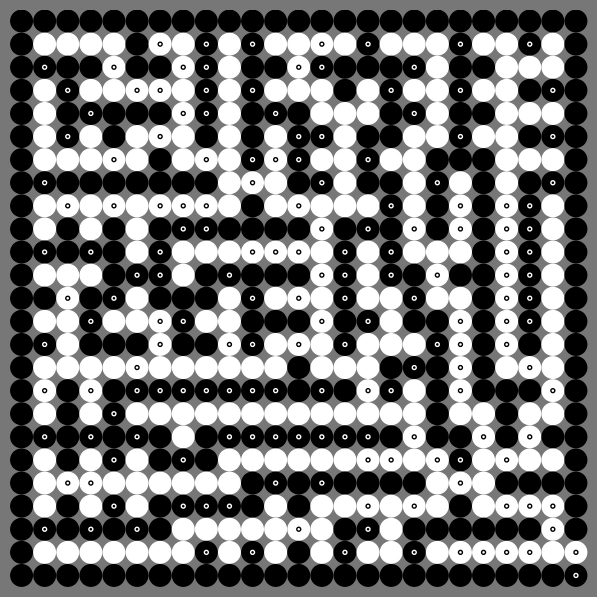

In [96]:
%%time
puzzle = np.loadtxt('data/yinyang03.txt', dtype=np.uint8)
cells, numbers, edges = solve_yinyang(puzzle)
plot_yinyang(puzzle, cells=cells);

パズルサイトには、片方の碁石しかない盤面もあります。これを解くには、プログラムを少し改造する必要があります。読者の皆さんも挑戦してみてください。